# Investments-Selected Quant Tools

## This is the notebook for the above course at 2023 spring, university of zurich, aiming to make portfolio investments using machine learning technologies.


In [1]:
# import all the library that we need
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing

# import classes from python files
from data_

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [2]:
# get the window for the data.

class WindowGenerator():
  def __init__(self, input_width, label_width, shift, input_columns=None, \
    label_columns=None, all_columns=None):  
    
    """_summary_
    
    input_ width: number of time steps of the data
    label_width: number of time steps of the prediction labels
    shift: number of time steps between the last input time step and 
           the first label time step, this one is not very sure
    """
    
    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.train_label_indices = {name: i for i, name in enumerate(train_df.columns)}

    # ...and the input column indices
    self.input_columns = input_columns
    if input_columns is not None:
      self.input_columns_indices = {name: i for i, name in enumerate(input_columns)}
    self.train_input_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.input_columns is not None:
        inputs = tf.stack([inputs[:, :, self.train_input_indices[name]] for name in self.input_columns], axis=-1)
      if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.train_label_indices[name]] for name in self.label_columns], axis=-1)
      return inputs, labels

  def make_dataset(self, data, shuffle = False, batchsize = 500,):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data, targets=None, sequence_length=self.total_window_size,
                                                                sequence_stride=1, sampling_rate=1, shuffle=shuffle, batch_size=batchsize)
      ds = ds.map(self.split_window)
      return ds

In [3]:
# class MyModel(tf.keras.Model):
#     def __init__(self, cnn_filters, cnn_kernel_size, rnn_units, autoencoder_latent_dim):
#         super(MyModel, self).__init__()

#         # Convolutional Neural Network (CNN)
#         self.cnn = tf.keras.Sequential([
#             tf.keras.layers.Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, activation='relu', use_bias=False),
#             tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'),
#             tf.keras.layers.Conv1D(filters=32, kernel_size=cnn_kernel_size, activation='relu', use_bias=False),
#             tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'),
#             tf.keras.layers.Conv1D(filters=4, kernel_size=lb - 2 * (cnn_kernel_size - 1) - (lw - 1), activation=None, use_bias=False),
#             tf.keras.layers.Dense(units=1)
#         ])

#         # Recurrent Neural Network (RNN)
#         self.rnn = tf.keras.Sequential([
#             tf.keras.layers.SimpleRNN(units=rnn_units, return_sequences=False, return_state=False, activation='tanh', use_bias=True),
#             tf.keras.layers.Dense(units=1, activation='tanh', use_bias=True)
#         ])

#         # Autoencoder
#         self.autoencoder_encoder = tf.keras.Sequential([
#             tf.keras.layers.Dense(units=autoencoder_latent_dim, activation='relu'),
#         ])
#         self.autoencoder_decoder = tf.keras.Sequential([
#             tf.keras.layers.Dense(units=lb, activation='relu'),
#         ])
#         self.autoencoder = tf.keras.Sequential([
#             self.autoencoder_encoder,
#             self.autoencoder_decoder
#         ])

#     def call(self, inputs, model_type):
#         if model_type == 'cnn':
#             return self.cnn(inputs)
#         elif model_type == 'rnn':
#             return self.rnn(inputs)
#         elif model_type == 'autoencoder':
#             return self.autoencoder(inputs)
#         else:
#             raise ValueError("Invalid model_type. Supported options are 'cnn', 'rnn', and 'autoencoder'.")

In [18]:
class CNNModel(tf.keras.Model):
    def __init__(self, cnn_filters, cnn_kernel_size):
        super(CNNModel, self).__init__()

        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, activation='relu', use_bias=False),
            tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'),
            tf.keras.layers.Conv1D(filters=32, kernel_size=cnn_kernel_size, activation='relu', use_bias=False),
            tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'),
            tf.keras.layers.Conv1D(filters=4, kernel_size=lb - 2 * (cnn_kernel_size - 1) - (lw - 1), activation=None, use_bias=False),
            tf.keras.layers.Dense(units=1)
        ])

    def call(self, inputs):
        return self.model(inputs)
    
    
    
class RNNModel(tf.keras.Model):
    def __init__(self, rnn_units, dropout_rate = 0.2):
        super(RNNModel, self).__init__()

        self.model = tf.keras.Sequential([
            tf.keras.layers.LSTM(units=rnn_units, return_sequences=True, activation='relu', use_bias=True),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(units=rnn_units, return_sequences=False, activation='relu', use_bias=True),
            tf.keras.layers.Dense(units=1, activation='sigmoid')
        ])
    def call(self, inputs):
        return self.model(inputs)


class AutoencoderModel(tf.keras.Model):
    def __init__(self, autoencoder_latent_dim):
        super(AutoencoderModel, self).__init__()

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(units=autoencoder_latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(units=lb, activation='relu'),
        ])
        self.model = tf.keras.Sequential([
            self.encoder,
            self.decoder
        ])

    def call(self, inputs):
        return self.model(inputs)

def create_model(model_type, cnn_filters=None, cnn_kernel_size=None, rnn_units=None, rnn_dropout_rate = None, autoencoder_latent_dim=None):
    if model_type == 'cnn':
        return CNNModel(cnn_filters, cnn_kernel_size)
    elif model_type == 'rnn':
        return RNNModel(rnn_units, rnn_dropout_rate)
    elif model_type == 'autoencoder':
        return AutoencoderModel(autoencoder_latent_dim)
    else:
        raise ValueError("Invalid model_type. Supported options are 'cnn', 'rnn', and 'autoencoder'.")


In [5]:
class DataProcessor:
    def __init__(self, data_file):
        self.data = pd.read_excel(data_file, sheet_name='US', engine='openpyxl')
        print(self.data.info())
        print(self.data.head())
        self.data = self.data.set_index(self.data['Date'])
        self.data = self.data.drop(columns='Date')
        self.data = self.data.dropna()

    def split_train_test(self, test_size=0.2):
        n = len(self.data)
        train_data = self.data.iloc[:int((1 - test_size) * n)]
        test_data = self.data.iloc[int((1 - test_size) * n):]
        return train_data, test_data

    def apply_standard_scaling(self, data):
        mm_scaler = preprocessing.StandardScaler()
        scaled_data = mm_scaler.fit_transform(data)
        scaled_df = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)
        return scaled_df

In [7]:
# set up the data.
data_processor = DataProcessor('market_data.xlsx')
train_data, test_data = data_processor.split_train_test(test_size=0.2)
train_df = data_processor.apply_standard_scaling(train_data)
test_df = data_processor.apply_standard_scaling(test_data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1833 entries, 0 to 1832
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1833 non-null   datetime64[ns]
 1   EMP     1833 non-null   float64       
 2   PE      1833 non-null   float64       
 3   CAPE    1833 non-null   float64       
 4   DY      1833 non-null   float64       
 5   Rho     1833 non-null   float64       
 6   MOV     1833 non-null   float64       
 7   IR      1833 non-null   float64       
 8   RR      1833 non-null   float64       
 9   Y02     1833 non-null   float64       
 10  Y10     1833 non-null   float64       
 11  STP     1833 non-null   float64       
 12  CF      1833 non-null   float64       
 13  MG      1833 non-null   float64       
 14  RV      1833 non-null   float64       
 15  ED      1833 non-null   float64       
 16  UN      1833 non-null   float64       
 17  GDP     1833 non-null   float64       
 18  M2      

In [8]:
# define sliding window
lf = 52     # look forward
#ks = 26     # kernel size
lw = 1      # label width
lb = 52

# look back
window = WindowGenerator(input_width=lb, label_width=lw, shift=lf, input_columns=['RV', 'MG'], label_columns=['ED'])
td = window.make_dataset(train_df, batchsize=150, shuffle=True)


# cross-validation
is_data = td.take(5)
os_data = td.skip(5)

In [9]:

cnn_filters = 64
cnn_kernel_size = 3
cnn_model = create_model('cnn', cnn_filters=cnn_filters, cnn_kernel_size=cnn_kernel_size)


# Define the learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=150, decay_rate=0.95, staircase=True)

# Compile the model
cnn_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.SGD(learning_rate=lr_schedule),
              metrics=[tf.metrics.MeanSquaredError()])

cnn_model.run_eagerly = False

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, mode='min')

# Train the model
history = cnn_model.fit(is_data, validation_data=os_data, epochs=500, batch_size=150, callbacks=[early_stopping])

# Print model summary
cnn_model.summary()




Epoch 1/500
5/5 [==============================] - 1s 49ms/step - loss: 1.0595 - mean_squared_error: 1.0595 - val_loss: 1.0686 - val_mean_squared_error: 1.0686
Epoch 2/500
5/5 [==============================] - 0s 25ms/step - loss: 0.9513 - mean_squared_error: 0.9513 - val_loss: 0.9124 - val_mean_squared_error: 0.9124
Epoch 3/500
5/5 [==============================] - 0s 26ms/step - loss: 0.8970 - mean_squared_error: 0.8970 - val_loss: 0.9489 - val_mean_squared_error: 0.9489
Epoch 4/500
5/5 [==============================] - 0s 26ms/step - loss: 0.8381 - mean_squared_error: 0.8381 - val_loss: 0.7996 - val_mean_squared_error: 0.7996
Epoch 5/500
5/5 [==============================] - 0s 27ms/step - loss: 0.8028 - mean_squared_error: 0.8028 - val_loss: 0.7993 - val_mean_squared_error: 0.7993
Epoch 6/500
5/5 [==============================] - 0s 27ms/step - loss: 0.7642 - mean_squared_error: 0.7642 - val_loss: 0.8312 - val_mean_squared_error: 0.8312
Epoch 7/500
5/5 [=======================

Epoch 52/500
5/5 [==============================] - 0s 52ms/step - loss: 0.5753 - mean_squared_error: 0.5753 - val_loss: 0.5836 - val_mean_squared_error: 0.5836
Epoch 53/500
5/5 [==============================] - 0s 40ms/step - loss: 0.5801 - mean_squared_error: 0.5801 - val_loss: 0.4683 - val_mean_squared_error: 0.4683
Epoch 54/500
5/5 [==============================] - 0s 53ms/step - loss: 0.5112 - mean_squared_error: 0.5112 - val_loss: 0.4827 - val_mean_squared_error: 0.4827
Epoch 55/500
5/5 [==============================] - 0s 55ms/step - loss: 0.5148 - mean_squared_error: 0.5148 - val_loss: 0.4501 - val_mean_squared_error: 0.4501
Epoch 56/500
5/5 [==============================] - 0s 51ms/step - loss: 0.4762 - mean_squared_error: 0.4762 - val_loss: 0.4963 - val_mean_squared_error: 0.4963
Epoch 57/500
5/5 [==============================] - 0s 52ms/step - loss: 0.4293 - mean_squared_error: 0.4293 - val_loss: 0.4718 - val_mean_squared_error: 0.4718
Epoch 58/500
5/5 [================

Epoch 103/500
5/5 [==============================] - 0s 56ms/step - loss: 0.3930 - mean_squared_error: 0.3930 - val_loss: 0.4118 - val_mean_squared_error: 0.4118
Epoch 104/500
5/5 [==============================] - 0s 53ms/step - loss: 0.5528 - mean_squared_error: 0.5528 - val_loss: 0.5068 - val_mean_squared_error: 0.5068
Epoch 105/500
5/5 [==============================] - 0s 52ms/step - loss: 0.4483 - mean_squared_error: 0.4483 - val_loss: 0.4421 - val_mean_squared_error: 0.4421
Epoch 106/500
5/5 [==============================] - 0s 53ms/step - loss: 0.4071 - mean_squared_error: 0.4071 - val_loss: 0.4335 - val_mean_squared_error: 0.4335
Epoch 107/500
5/5 [==============================] - 0s 51ms/step - loss: 0.3852 - mean_squared_error: 0.3852 - val_loss: 0.3771 - val_mean_squared_error: 0.3771
Epoch 108/500
5/5 [==============================] - 0s 54ms/step - loss: 0.5577 - mean_squared_error: 0.5577 - val_loss: 0.6402 - val_mean_squared_error: 0.6402
Epoch 109/500
5/5 [=========

5/5 [==============================] - 0s 52ms/step - loss: 0.3194 - mean_squared_error: 0.3194 - val_loss: 0.3201 - val_mean_squared_error: 0.3201
Epoch 154/500
5/5 [==============================] - 0s 55ms/step - loss: 0.3249 - mean_squared_error: 0.3249 - val_loss: 0.2864 - val_mean_squared_error: 0.2864
Epoch 155/500
5/5 [==============================] - 0s 51ms/step - loss: 0.3207 - mean_squared_error: 0.3207 - val_loss: 0.3585 - val_mean_squared_error: 0.3585
Epoch 156/500
5/5 [==============================] - 0s 54ms/step - loss: 0.3720 - mean_squared_error: 0.3720 - val_loss: 0.3806 - val_mean_squared_error: 0.3806
Epoch 157/500
5/5 [==============================] - 0s 57ms/step - loss: 0.3764 - mean_squared_error: 0.3764 - val_loss: 0.3790 - val_mean_squared_error: 0.3790
Epoch 158/500
5/5 [==============================] - 0s 57ms/step - loss: 0.4042 - mean_squared_error: 0.4042 - val_loss: 0.3244 - val_mean_squared_error: 0.3244
Epoch 159/500
5/5 [=======================

Epoch 204/500
5/5 [==============================] - 0s 53ms/step - loss: 0.2508 - mean_squared_error: 0.2508 - val_loss: 0.2632 - val_mean_squared_error: 0.2632
Epoch 205/500
5/5 [==============================] - 0s 49ms/step - loss: 0.2478 - mean_squared_error: 0.2478 - val_loss: 0.2542 - val_mean_squared_error: 0.2542
Epoch 206/500
5/5 [==============================] - 0s 39ms/step - loss: 0.2605 - mean_squared_error: 0.2605 - val_loss: 0.3150 - val_mean_squared_error: 0.3150
Epoch 207/500
5/5 [==============================] - 0s 60ms/step - loss: 0.2437 - mean_squared_error: 0.2437 - val_loss: 0.2595 - val_mean_squared_error: 0.2595
Epoch 208/500
5/5 [==============================] - 0s 50ms/step - loss: 0.2365 - mean_squared_error: 0.2365 - val_loss: 0.3264 - val_mean_squared_error: 0.3264
Epoch 209/500
5/5 [==============================] - 0s 51ms/step - loss: 0.2623 - mean_squared_error: 0.2623 - val_loss: 0.2434 - val_mean_squared_error: 0.2434
Epoch 210/500
5/5 [=========

5/5 [==============================] - 0s 35ms/step - loss: 0.1971 - mean_squared_error: 0.1971 - val_loss: 0.2134 - val_mean_squared_error: 0.2134
Epoch 255/500
5/5 [==============================] - 0s 31ms/step - loss: 0.1819 - mean_squared_error: 0.1819 - val_loss: 0.1841 - val_mean_squared_error: 0.1841
Epoch 256/500
5/5 [==============================] - 0s 49ms/step - loss: 0.1858 - mean_squared_error: 0.1858 - val_loss: 0.2102 - val_mean_squared_error: 0.2102
Epoch 257/500
5/5 [==============================] - 0s 55ms/step - loss: 0.2158 - mean_squared_error: 0.2158 - val_loss: 0.2068 - val_mean_squared_error: 0.2068
Epoch 258/500
5/5 [==============================] - 0s 44ms/step - loss: 0.1921 - mean_squared_error: 0.1921 - val_loss: 0.1775 - val_mean_squared_error: 0.1775
Epoch 259/500
5/5 [==============================] - 0s 55ms/step - loss: 0.2003 - mean_squared_error: 0.2003 - val_loss: 0.1960 - val_mean_squared_error: 0.1960
Epoch 260/500
5/5 [=======================

Epoch 305/500
5/5 [==============================] - 0s 44ms/step - loss: 0.2564 - mean_squared_error: 0.2564 - val_loss: 0.1648 - val_mean_squared_error: 0.1648
Epoch 306/500
5/5 [==============================] - 0s 47ms/step - loss: 0.1671 - mean_squared_error: 0.1671 - val_loss: 0.1556 - val_mean_squared_error: 0.1556
Epoch 307/500
5/5 [==============================] - 0s 58ms/step - loss: 0.1614 - mean_squared_error: 0.1614 - val_loss: 0.1658 - val_mean_squared_error: 0.1658
Epoch 308/500
5/5 [==============================] - 0s 52ms/step - loss: 0.1654 - mean_squared_error: 0.1654 - val_loss: 0.1714 - val_mean_squared_error: 0.1714
Epoch 309/500
5/5 [==============================] - 0s 44ms/step - loss: 0.1608 - mean_squared_error: 0.1608 - val_loss: 0.1616 - val_mean_squared_error: 0.1616
Epoch 310/500
5/5 [==============================] - 0s 45ms/step - loss: 0.1640 - mean_squared_error: 0.1640 - val_loss: 0.1609 - val_mean_squared_error: 0.1609
Epoch 311/500
5/5 [=========

5/5 [==============================] - 0s 55ms/step - loss: 0.1497 - mean_squared_error: 0.1497 - val_loss: 0.1457 - val_mean_squared_error: 0.1457
Epoch 356/500
5/5 [==============================] - 0s 50ms/step - loss: 0.1391 - mean_squared_error: 0.1391 - val_loss: 0.1449 - val_mean_squared_error: 0.1449
Epoch 357/500
5/5 [==============================] - 0s 52ms/step - loss: 0.1382 - mean_squared_error: 0.1382 - val_loss: 0.1281 - val_mean_squared_error: 0.1281
Epoch 358/500
5/5 [==============================] - 0s 52ms/step - loss: 0.1410 - mean_squared_error: 0.1410 - val_loss: 0.1346 - val_mean_squared_error: 0.1346
Epoch 359/500
5/5 [==============================] - 0s 60ms/step - loss: 0.1276 - mean_squared_error: 0.1276 - val_loss: 0.1497 - val_mean_squared_error: 0.1497
Epoch 360/500
5/5 [==============================] - 0s 59ms/step - loss: 0.1520 - mean_squared_error: 0.1520 - val_loss: 0.1297 - val_mean_squared_error: 0.1297
Epoch 361/500
5/5 [=======================

Epoch 406/500
5/5 [==============================] - 0s 43ms/step - loss: 0.1463 - mean_squared_error: 0.1463 - val_loss: 0.1163 - val_mean_squared_error: 0.1163
Epoch 407/500
5/5 [==============================] - 0s 58ms/step - loss: 0.1260 - mean_squared_error: 0.1260 - val_loss: 0.1235 - val_mean_squared_error: 0.1235
Epoch 408/500
5/5 [==============================] - 0s 56ms/step - loss: 0.1173 - mean_squared_error: 0.1173 - val_loss: 0.1145 - val_mean_squared_error: 0.1145
Epoch 409/500
5/5 [==============================] - 0s 51ms/step - loss: 0.1089 - mean_squared_error: 0.1089 - val_loss: 0.1237 - val_mean_squared_error: 0.1237
Epoch 410/500
5/5 [==============================] - 0s 53ms/step - loss: 0.1157 - mean_squared_error: 0.1157 - val_loss: 0.1071 - val_mean_squared_error: 0.1071
Epoch 411/500
5/5 [==============================] - 0s 41ms/step - loss: 0.1050 - mean_squared_error: 0.1050 - val_loss: 0.3055 - val_mean_squared_error: 0.3055
Epoch 412/500
5/5 [=========

5/5 [==============================] - 0s 46ms/step - loss: 0.1098 - mean_squared_error: 0.1098 - val_loss: 0.0847 - val_mean_squared_error: 0.0847
Epoch 457/500
5/5 [==============================] - 0s 47ms/step - loss: 0.0903 - mean_squared_error: 0.0903 - val_loss: 0.0993 - val_mean_squared_error: 0.0993
Epoch 458/500
5/5 [==============================] - 0s 55ms/step - loss: 0.1013 - mean_squared_error: 0.1013 - val_loss: 0.1091 - val_mean_squared_error: 0.1091
Epoch 459/500
5/5 [==============================] - 0s 63ms/step - loss: 0.1118 - mean_squared_error: 0.1118 - val_loss: 0.1074 - val_mean_squared_error: 0.1074
Epoch 460/500
5/5 [==============================] - 0s 48ms/step - loss: 0.1075 - mean_squared_error: 0.1075 - val_loss: 0.0992 - val_mean_squared_error: 0.0992
Epoch 461/500
5/5 [==============================] - 0s 51ms/step - loss: 0.1035 - mean_squared_error: 0.1035 - val_loss: 0.1125 - val_mean_squared_error: 0.1125
Epoch 462/500
5/5 [=======================

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf


class ModelPerformanceVisualizer:
    def __init__(self, model, eval_train, eval_test, train_df, test_df, df1, df2, lb, lf):
        self.model = model
        self.eval_train = eval_train
        self.eval_test = eval_test
        self.train_df = train_df
        self.test_df = test_df
        self.df1 = df1
        self.df2 = df2
        self.lb = lb
        self.lf = lf
        self.y_pred = 0
        self.y_true = 0
        

    def plot_loss(self, history):
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.legend(['training loss', 'validation loss'])
        plt.show()

    def plot_in_sample_performance(self):
        plt.subplot(221)
        self.y_pred = self.model.predict(self.eval_train)
        self.y_true = tf.concat([y for x, y in self.eval_train], axis=0)
        mse = tf.reduce_mean(tf.keras.losses.MSE(self.y_true, self.y_pred))

        plt.plot(self.train_df.index[self.lb + self.lf - 1:], self.y_true[:, -1, -1])
        plt.plot(self.train_df.index[self.lb + self.lf - 1:], self.y_pred[:, -1], '--')
        plt.title('in-sample mse = %1.2f' % mse)
        plt.legend(['self.y_true', 'self.y_pred'])

    def plot_in_sample_trading_strategy(self):
        plt.subplot(222)
        y_mkt = self.df1.iloc[self.lb + self.lf - 1:, :].loc[:, '_MKT']
        pos = tf.sign(tf.squeeze(self.y_pred[:, -1]))
        pos = tf.where(tf.equal(pos, -1), 0, pos)

        pnl = pos[1:] * y_mkt[:-1]
        pnl2 = pos[2:] * y_mkt[:-2]

        plt.plot(y_mkt.index[:-1], tf.cumsum(pnl))
        plt.plot(y_mkt.index[:-2], tf.cumsum(pnl2), '--')
        plt.plot(y_mkt.index[:-1], tf.cumsum(y_mkt[:-1]))

        tmp = pnl - y_mkt[:-1]
        sr = np.mean(tmp.numpy()) / np.std(tmp.numpy()) * tf.sqrt(52.00)
        plt.title('in-sample IR = %1.2f' % sr)
        plt.legend(['pnl [t+1]', 'pnl [t+2]', 'underlying'])

    def plot_out_of_sample_performance(self):
        plt.subplot(223)
        self.y_pred = self.model.predict(self.eval_test)
        self.y_true = tf.concat([y for x, y in self.eval_test], axis=0)
        mse = tf.reduce_mean(tf.keras.losses.MSE(self.y_true, self.y_pred))

        plt.plot(self.test_df.index[self.lb + self.lf - 1:], self.y_true[:, -1, -1])
        plt.plot(self.test_df.index[self.lb + self.lf - 1:], self.y_pred[:, -1], '--')
        plt.title('out-of-sample mse = %1.2f' % mse)
        plt.legend(['self.y_true', 'self.y_pred'])

    def plot_out_of_sample_trading_strategy(self):
        plt.subplot(224)
        y_mkt = self.df2.iloc[self.lb + self.lf - 1:, :].loc[:, '_MKT']
        pos = tf.sign(tf.squeeze(self.y_pred[:, -1]))
        pos = tf.where(tf.equal(pos, -1), 0, pos)

        pnl = pos[1:] * y_mkt[:-1]
        pnl2 = pos[2:] * y_mkt[:-2]

        plt.plot(y_mkt.index[:-1], tf.cumsum(pnl))
        plt.plot(y_mkt.index[:-2], tf.cumsum(pnl2), '--')
        plt.plot(y_mkt.index[:-1], tf.cumsum(y_mkt[:-1]))

        tmp = pnl - y_mkt[:-1]
        sr = np.mean(tmp.numpy()) / np.std(tmp.numpy()) * tf.sqrt(52.00)
        plt.title('out-of-sample IR = %1.2f' % sr)
        plt.legend(['pnl [t+1]', 'pnl [t+2]', 'underlying'])

    def show_plots(self):
        plt.show()


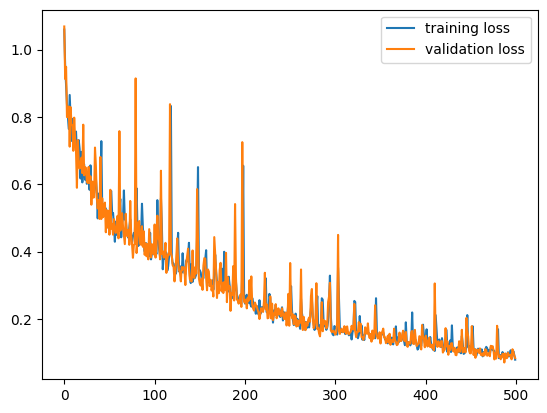

1/1 [==============================] - 0s 81ms/step


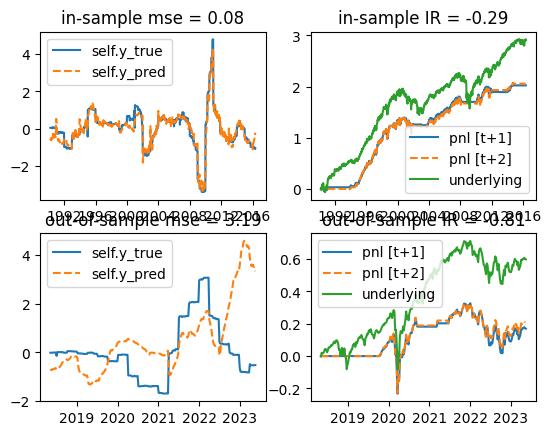

In [11]:

eval_train = window.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test = window.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)
# Create an instance of the ModelPerformanceVisualizer class
visualizer = ModelPerformanceVisualizer(cnn_model, eval_train, eval_test, train_df, test_df, train_data, test_data, lb, lf)

# Plot loss history
visualizer.plot_loss(history)

# Plot in-sample performance
visualizer.plot_in_sample_performance()

# Plot in-sample trading strategy
visualizer.plot_in_sample_trading_strategy()

# Plot out-of-sample performance
visualizer.plot_out_of_sample_performance()

# Plot out-of-sample trading strategy
visualizer.plot_out_of_sample_trading_strategy()

# Display all plots
visualizer.show_plots()


## RNN model

In [19]:


rnn_units = 128
dropout_rate = 0.2

rnn_model = create_model('rnn', rnn_units = 256)

# define the learning rate schedules
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=150, decay_rate=0.95, staircase=True)

# Compile the model
rnn_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.SGD(learning_rate=lr_schedule),
              metrics=[tf.metrics.MeanSquaredError()])

rnn_model.run_eagerly = False

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, mode='min')

# Train the model
history = rnn_model.fit(is_data, validation_data=os_data, epochs=500, batch_size=150, callbacks=[early_stopping])

# Print model summary
rnn_model.summary()


Epoch 1/500
5/5 [==============================] - 6s 632ms/step - loss: 1.2780 - mean_squared_error: 1.2780 - val_loss: 1.3898 - val_mean_squared_error: 1.3898
Epoch 2/500
5/5 [==============================] - 3s 627ms/step - loss: 1.2779 - mean_squared_error: 1.2779 - val_loss: 1.2288 - val_mean_squared_error: 1.2288
Epoch 3/500
5/5 [==============================] - 3s 648ms/step - loss: 1.3155 - mean_squared_error: 1.3155 - val_loss: 1.2832 - val_mean_squared_error: 1.2832
Epoch 4/500
5/5 [==============================] - 3s 648ms/step - loss: 1.3124 - mean_squared_error: 1.3124 - val_loss: 1.2737 - val_mean_squared_error: 1.2737
Epoch 5/500
5/5 [==============================] - 3s 623ms/step - loss: 1.2788 - mean_squared_error: 1.2788 - val_loss: 1.3619 - val_mean_squared_error: 1.3619
Epoch 6/500
5/5 [==============================] - 3s 671ms/step - loss: 1.2876 - mean_squared_error: 1.2876 - val_loss: 1.3830 - val_mean_squared_error: 1.3830
Epoch 7/500
5/5 [=================

5/5 [==============================] - 3s 693ms/step - loss: 1.2197 - mean_squared_error: 1.2197 - val_loss: 1.0103 - val_mean_squared_error: 1.0103
Epoch 52/500
5/5 [==============================] - 3s 682ms/step - loss: 1.1281 - mean_squared_error: 1.1281 - val_loss: 1.0605 - val_mean_squared_error: 1.0605
Epoch 53/500
5/5 [==============================] - 3s 675ms/step - loss: 1.1372 - mean_squared_error: 1.1372 - val_loss: 0.9825 - val_mean_squared_error: 0.9825
Epoch 54/500
5/5 [==============================] - 3s 655ms/step - loss: 1.2374 - mean_squared_error: 1.2374 - val_loss: 1.1651 - val_mean_squared_error: 1.1651
Epoch 55/500
5/5 [==============================] - 3s 698ms/step - loss: 1.1392 - mean_squared_error: 1.1392 - val_loss: 1.0567 - val_mean_squared_error: 1.0567
Epoch 56/500
5/5 [==============================] - 3s 682ms/step - loss: 1.0541 - mean_squared_error: 1.0541 - val_loss: 0.8787 - val_mean_squared_error: 0.8787
Epoch 57/500
5/5 [=======================

Epoch 102/500
5/5 [==============================] - 3s 715ms/step - loss: 1.0432 - mean_squared_error: 1.0432 - val_loss: 1.0398 - val_mean_squared_error: 1.0398
Epoch 103/500
5/5 [==============================] - 3s 675ms/step - loss: 0.8873 - mean_squared_error: 0.8873 - val_loss: 1.0755 - val_mean_squared_error: 1.0755
Epoch 104/500
5/5 [==============================] - 4s 753ms/step - loss: 0.9674 - mean_squared_error: 0.9674 - val_loss: 0.9851 - val_mean_squared_error: 0.9851
Epoch 105/500
5/5 [==============================] - 3s 694ms/step - loss: 1.0092 - mean_squared_error: 1.0092 - val_loss: 0.9076 - val_mean_squared_error: 0.9076
Epoch 106/500
5/5 [==============================] - 3s 683ms/step - loss: 1.0276 - mean_squared_error: 1.0276 - val_loss: 1.0037 - val_mean_squared_error: 1.0037
Epoch 107/500
5/5 [==============================] - 3s 620ms/step - loss: 1.0186 - mean_squared_error: 1.0186 - val_loss: 0.8918 - val_mean_squared_error: 0.8918
Epoch 108/500
5/5 [===

5/5 [==============================] - 3s 692ms/step - loss: 0.9348 - mean_squared_error: 0.9348 - val_loss: 0.9615 - val_mean_squared_error: 0.9615
Epoch 153/500
5/5 [==============================] - 3s 672ms/step - loss: 0.8666 - mean_squared_error: 0.8666 - val_loss: 0.9808 - val_mean_squared_error: 0.9808
Epoch 154/500
5/5 [==============================] - 4s 735ms/step - loss: 0.9455 - mean_squared_error: 0.9455 - val_loss: 0.9378 - val_mean_squared_error: 0.9378
Epoch 155/500
5/5 [==============================] - 3s 704ms/step - loss: 0.9232 - mean_squared_error: 0.9232 - val_loss: 0.8543 - val_mean_squared_error: 0.8543
Epoch 156/500
5/5 [==============================] - 3s 609ms/step - loss: 0.9068 - mean_squared_error: 0.9068 - val_loss: 0.9736 - val_mean_squared_error: 0.9736
Epoch 157/500
5/5 [==============================] - 3s 560ms/step - loss: 1.0264 - mean_squared_error: 1.0264 - val_loss: 0.8896 - val_mean_squared_error: 0.8896
Epoch 158/500
5/5 [=================

5/5 [==============================] - 3s 700ms/step - loss: 0.8560 - mean_squared_error: 0.8560 - val_loss: 0.8361 - val_mean_squared_error: 0.8361
Epoch 203/500
5/5 [==============================] - 3s 683ms/step - loss: 1.0194 - mean_squared_error: 1.0194 - val_loss: 0.8987 - val_mean_squared_error: 0.8987
Epoch 204/500
5/5 [==============================] - 3s 703ms/step - loss: 0.9632 - mean_squared_error: 0.9632 - val_loss: 0.9333 - val_mean_squared_error: 0.9333
Epoch 205/500
5/5 [==============================] - 3s 708ms/step - loss: 0.9399 - mean_squared_error: 0.9399 - val_loss: 0.9840 - val_mean_squared_error: 0.9840
Epoch 206/500
5/5 [==============================] - 3s 699ms/step - loss: 0.8962 - mean_squared_error: 0.8962 - val_loss: 0.9054 - val_mean_squared_error: 0.9054
Epoch 207/500
5/5 [==============================] - 3s 687ms/step - loss: 0.9536 - mean_squared_error: 0.9536 - val_loss: 0.9849 - val_mean_squared_error: 0.9849
Epoch 208/500
5/5 [=================

5/5 [==============================] - 3s 703ms/step - loss: 0.8148 - mean_squared_error: 0.8148 - val_loss: 0.9139 - val_mean_squared_error: 0.9139
Epoch 253/500
5/5 [==============================] - 3s 705ms/step - loss: 0.8244 - mean_squared_error: 0.8244 - val_loss: 0.9757 - val_mean_squared_error: 0.9757
Epoch 254/500
5/5 [==============================] - 3s 661ms/step - loss: 0.9142 - mean_squared_error: 0.9142 - val_loss: 0.9689 - val_mean_squared_error: 0.9689
Epoch 255/500
5/5 [==============================] - 3s 579ms/step - loss: 0.8431 - mean_squared_error: 0.8431 - val_loss: 0.8718 - val_mean_squared_error: 0.8718
Epoch 256/500
5/5 [==============================] - 3s 695ms/step - loss: 0.8591 - mean_squared_error: 0.8591 - val_loss: 0.8437 - val_mean_squared_error: 0.8437
Epoch 257/500
5/5 [==============================] - 3s 670ms/step - loss: 0.8417 - mean_squared_error: 0.8417 - val_loss: 0.8973 - val_mean_squared_error: 0.8973
Epoch 258/500
5/5 [=================

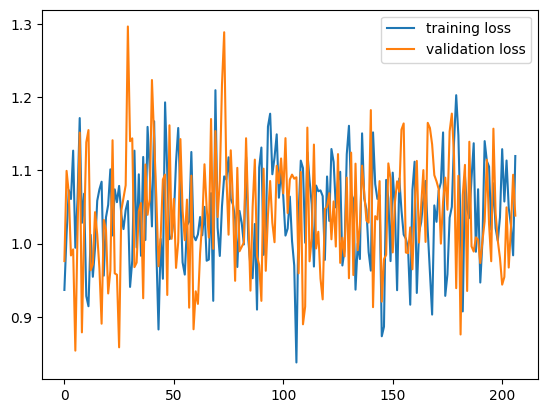

1/1 [==============================] - 2s 2s/step


C:\Users\Guo_y\AppData\Local\Temp\ipykernel_20080\3755800425.py:51: RuntimeWarning: invalid value encountered in float_scalars
  sr = np.mean(tmp.numpy()) / np.std(tmp.numpy()) * tf.sqrt(52.00)


1/1 [==============================] - 0s 390ms/step


C:\Users\Guo_y\AppData\Local\Temp\ipykernel_20080\3755800425.py:80: RuntimeWarning: invalid value encountered in float_scalars
  sr = np.mean(tmp.numpy()) / np.std(tmp.numpy()) * tf.sqrt(52.00)


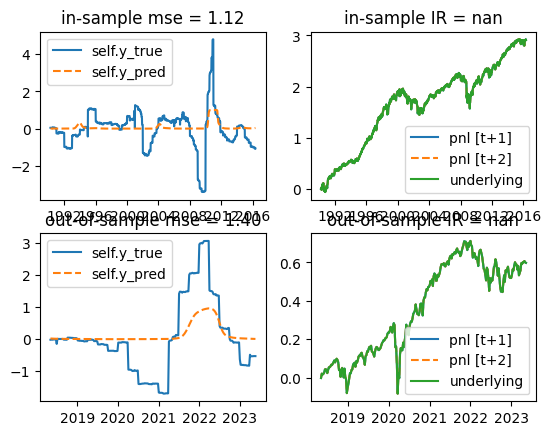

In [27]:
eval_train_rnn = window.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test_rnn = window.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)
# Create an instance of the ModelPerformanceVisualizer class
visualizer = ModelPerformanceVisualizer(rnn_model, eval_train_rnn, eval_test_rnn, train_df, test_df, train_data, test_data, lb, lf)

# Plot loss history
visualizer.plot_loss(history)

# Plot in-sample performance
visualizer.plot_in_sample_performance()

# Plot in-sample trading strategy
visualizer.plot_in_sample_trading_strategy()

# Plot out-of-sample performance
visualizer.plot_out_of_sample_performance()

# Plot out-of-sample trading strategy
visualizer.plot_out_of_sample_trading_strategy()

# Display all plots
visualizer.show_plots()

## Autoencoder Model

In [23]:
autoencoder_units = 128
dropout_rate = 0.2
autoencoder_latent_dim = 1
autoencoder_model = create_model('autoencoder', autoencoder_latent_dim = 1)

# define the learning rate schedules
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=150, decay_rate=0.95, staircase=True)

# Compile the model
autoencoder_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.SGD(learning_rate=lr_schedule),
              metrics=[tf.metrics.MeanSquaredError()])

autoencoder_model.run_eagerly = False

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, mode='min')

# Train the model
history = autoencoder_model.fit(is_data, validation_data=os_data, epochs=500, batch_size=150, callbacks=[early_stopping])

# Print model summary
autoencoder_model.summary()

Epoch 1/500
5/5 [==============================] - 1s 79ms/step - loss: 0.9367 - mean_squared_error: 0.9367 - val_loss: 0.9762 - val_mean_squared_error: 0.9762
Epoch 2/500
5/5 [==============================] - 0s 34ms/step - loss: 1.0129 - mean_squared_error: 1.0129 - val_loss: 1.0994 - val_mean_squared_error: 1.0994
Epoch 3/500
5/5 [==============================] - 0s 35ms/step - loss: 1.0730 - mean_squared_error: 1.0730 - val_loss: 1.0693 - val_mean_squared_error: 1.0693
Epoch 4/500
5/5 [==============================] - 0s 42ms/step - loss: 1.0609 - mean_squared_error: 1.0609 - val_loss: 0.9838 - val_mean_squared_error: 0.9838
Epoch 5/500
5/5 [==============================] - 0s 40ms/step - loss: 1.1270 - mean_squared_error: 1.1270 - val_loss: 0.9921 - val_mean_squared_error: 0.9921
Epoch 6/500
5/5 [==============================] - 0s 36ms/step - loss: 0.9944 - mean_squared_error: 0.9944 - val_loss: 0.8538 - val_mean_squared_error: 0.8538
Epoch 7/500
5/5 [=======================

Epoch 52/500
5/5 [==============================] - 0s 37ms/step - loss: 1.1113 - mean_squared_error: 1.1113 - val_loss: 0.9668 - val_mean_squared_error: 0.9668
Epoch 53/500
5/5 [==============================] - 0s 42ms/step - loss: 1.1580 - mean_squared_error: 1.1580 - val_loss: 1.0021 - val_mean_squared_error: 1.0021
Epoch 54/500
5/5 [==============================] - 0s 44ms/step - loss: 1.0651 - mean_squared_error: 1.0651 - val_loss: 1.1428 - val_mean_squared_error: 1.1428
Epoch 55/500
5/5 [==============================] - 0s 37ms/step - loss: 0.9744 - mean_squared_error: 0.9744 - val_loss: 1.0447 - val_mean_squared_error: 1.0447
Epoch 56/500
5/5 [==============================] - 0s 39ms/step - loss: 0.9577 - mean_squared_error: 0.9577 - val_loss: 1.0047 - val_mean_squared_error: 1.0047
Epoch 57/500
5/5 [==============================] - 0s 41ms/step - loss: 1.0250 - mean_squared_error: 1.0250 - val_loss: 1.0601 - val_mean_squared_error: 1.0601
Epoch 58/500
5/5 [================

Epoch 103/500
5/5 [==============================] - 0s 36ms/step - loss: 1.0205 - mean_squared_error: 1.0205 - val_loss: 1.0418 - val_mean_squared_error: 1.0418
Epoch 104/500
5/5 [==============================] - 0s 37ms/step - loss: 1.0642 - mean_squared_error: 1.0642 - val_loss: 1.0875 - val_mean_squared_error: 1.0875
Epoch 105/500
5/5 [==============================] - 0s 32ms/step - loss: 1.0037 - mean_squared_error: 1.0037 - val_loss: 1.0943 - val_mean_squared_error: 1.0943
Epoch 106/500
5/5 [==============================] - 0s 42ms/step - loss: 0.9701 - mean_squared_error: 0.9701 - val_loss: 1.0887 - val_mean_squared_error: 1.0887
Epoch 107/500
5/5 [==============================] - 0s 42ms/step - loss: 0.8376 - mean_squared_error: 0.8376 - val_loss: 1.0906 - val_mean_squared_error: 1.0906
Epoch 108/500
5/5 [==============================] - 0s 33ms/step - loss: 1.0408 - mean_squared_error: 1.0408 - val_loss: 0.9594 - val_mean_squared_error: 0.9594
Epoch 109/500
5/5 [=========

5/5 [==============================] - 0s 39ms/step - loss: 0.9363 - mean_squared_error: 0.9363 - val_loss: 1.0851 - val_mean_squared_error: 1.0851
Epoch 154/500
5/5 [==============================] - 0s 44ms/step - loss: 1.0890 - mean_squared_error: 1.0890 - val_loss: 1.0709 - val_mean_squared_error: 1.0709
Epoch 155/500
5/5 [==============================] - 0s 46ms/step - loss: 1.0454 - mean_squared_error: 1.0454 - val_loss: 1.1558 - val_mean_squared_error: 1.1558
Epoch 156/500
5/5 [==============================] - 0s 34ms/step - loss: 1.0123 - mean_squared_error: 1.0123 - val_loss: 1.1642 - val_mean_squared_error: 1.1642
Epoch 157/500
5/5 [==============================] - 0s 31ms/step - loss: 1.0067 - mean_squared_error: 1.0067 - val_loss: 0.9879 - val_mean_squared_error: 0.9879
Epoch 158/500
5/5 [==============================] - 0s 39ms/step - loss: 0.9940 - mean_squared_error: 0.9940 - val_loss: 0.9870 - val_mean_squared_error: 0.9870
Epoch 159/500
5/5 [=======================

Epoch 204/500
5/5 [==============================] - 0s 43ms/step - loss: 1.0488 - mean_squared_error: 1.0488 - val_loss: 0.9673 - val_mean_squared_error: 0.9673
Epoch 205/500
5/5 [==============================] - 0s 41ms/step - loss: 1.0254 - mean_squared_error: 1.0254 - val_loss: 1.0213 - val_mean_squared_error: 1.0213
Epoch 206/500
5/5 [==============================] - 0s 39ms/step - loss: 0.9840 - mean_squared_error: 0.9840 - val_loss: 1.0941 - val_mean_squared_error: 1.0941
Epoch 207/500
5/5 [==============================] - 0s 41ms/step - loss: 1.1196 - mean_squared_error: 1.1196 - val_loss: 1.0383 - val_mean_squared_error: 1.0383
Model: "autoencoder_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, None, 1)           3         
                                                                 
 sequential_4 (Sequential)   (None, None, 52)          104 

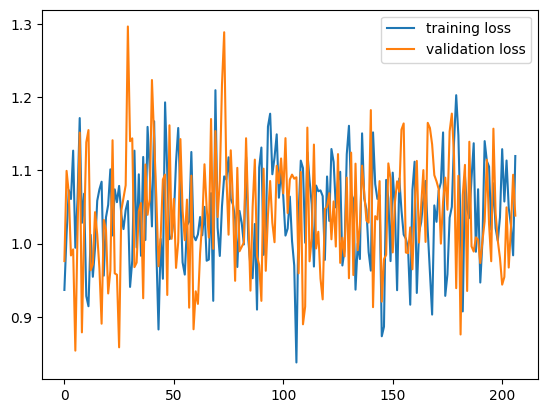

1/1 [==============================] - 0s 409ms/step


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [1362,52] vs. [1362] [Op:Mul]

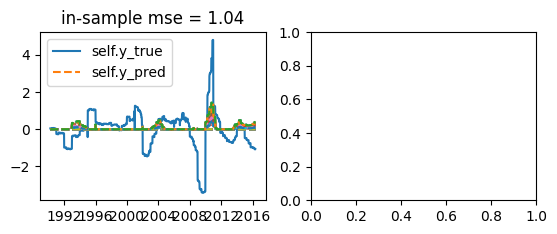

In [28]:
eval_train_autoencoder = window.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test_autoencoder = window.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)
# Create an instance of the ModelPerformanceVisualizer class
visualizer = ModelPerformanceVisualizer(autoencoder_model, eval_train_autoencoder, eval_test_autoencoder, train_df, test_df, train_data, test_data, lb, lf)

# Plot loss history
visualizer.plot_loss(history)

# Plot in-sample performance
visualizer.plot_in_sample_performance()

# Plot in-sample trading strategy
visualizer.plot_in_sample_trading_strategy()

# Plot out-of-sample performance
visualizer.plot_out_of_sample_performance()

# Plot out-of-sample trading strategy
visualizer.plot_out_of_sample_trading_strategy()

# Display all plots
visualizer.show_plots()